In [369]:
import torch
import torch.nn.functional as F
import torch.nn as nn
from math import sqrt
import matplotlib.pyplot as plt

In [425]:
with open('dataset.txt') as f:
	text = f.read()

vocabulary = sorted(list(set(text)))
vocab_size = len(vocabulary)

stoi = {v:i for i, v in enumerate(vocabulary)}
itos = {i:v for i, v in enumerate(vocabulary)}

def encode(s): return [stoi[c] for c in s]
def decode(i): return [itos[n] for n in i]

In [434]:
data = torch.tensor(encode(text))

split_v = int(0.9 * len(data))

train = data[:split_v]
test = data[split_v:]

print(len(train), len(test))

1003853 111540


In [435]:
batch_size = 16
block_size = 64
embedding_dimensions = 64
num_heads = 4
head_size = embedding_dimensions // num_heads
num_decoders = 4
learning_rate = 0.001
iterations = 20000
device = 'mps'

In [439]:
def get_batch(data):
    indexes = torch.randint(0, len(data)-block_size, (batch_size,))
    inputs = torch.stack([data[i:i+block_size] for i in indexes]).to(device)
    outputs = torch.stack([data[i+1:i+block_size+1] for i in indexes]).to(device)

    return inputs, outputs

In [421]:
class FeedForward(nn.Module):
	def __init__(self):
		super().__init__()
		self.network = nn.Sequential(
			nn.Linear(embedding_dimensions, embedding_dimensions),
			nn.ReLU(),
			nn.Linear(embedding_dimensions, embedding_dimensions)
		)

	def forward(self, data):
		return self.network(data)
	
test = FeedForward().forward(torch.randn(embedding_dimensions))

In [422]:
class AttentionHead(nn.Module):
	def __init__(self):
		super().__init__()
		self.key = nn.Linear(embedding_dimensions, head_size, bias=False)
		self.query = nn.Linear(embedding_dimensions, head_size, bias=False)
		self.value = nn.Linear(embedding_dimensions, head_size, bias=False)
		self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))

	def forward(self, data):
		batches, time, channels = data.shape

		key, query, value = self.key(data), self.query(data), self.value(data)
		mat_mul_1 = query @ key.transpose(-2, -1)
		scaled = mat_mul_1 / sqrt(channels)
		mask = scaled.masked_fill(self.tril == 0, float('-inf'))
		softmax = F.softmax(mask, dim=-1)
		out = softmax @ value

		return out

test = AttentionHead().forward(torch.randn((batch_size, block_size, embedding_dimensions)))

In [423]:
class MultiHeadAttention(nn.Module):
	def __init__(self):
		super().__init__()
		self.heads = nn.ModuleList([AttentionHead() for _ in range(num_heads)])
		self.projection = nn.Linear(embedding_dimensions, embedding_dimensions)
	
	def forward(self, data):
		return self.projection(torch.cat([head(data) for head in self.heads], dim=-1))

test = MultiHeadAttention().forward(torch.randn((batch_size, block_size, embedding_dimensions)))

In [427]:
class DecoderBlock(nn.Module):
	def __init__(self):
		super().__init__()
		self.attention = MultiHeadAttention()
		self.norm1 = nn.LayerNorm(embedding_dimensions)
		self.feed_forward = FeedForward()
		self.norm2 = nn.LayerNorm(embedding_dimensions)

	def forward(self, data):
		data = data + self.attention(self.norm1(data))
		data = data + self.feed_forward(self.norm2(data))

		return data

test = DecoderBlock().forward(torch.randn((batch_size, block_size, embedding_dimensions)))

In [437]:
class GPT(nn.Module):
	def __init__(self):
		super().__init__()
		self.embedding_space     = nn.Embedding(vocab_size, embedding_dimensions)
		self.positional_encoding = nn.Embedding(block_size, embedding_dimensions)
		self.blocks = nn.Sequential(*[DecoderBlock() for _ in range(num_decoders)])
		self.norm = nn.LayerNorm(embedding_dimensions)
		self.linear = nn.Linear(embedding_dimensions, vocab_size)
		
	def forward(self, data, outputs=None):
		batches, time = data.shape

		data = self.embedding_space(data) + self.positional_encoding(torch.arange(time, device=device))
		data = self.blocks(data)
		logits = self.linear(data)

		if outputs is not None:
			batches, time, channels = logits.shape
			loss = F.cross_entropy(logits.view(batches*time, channels), outputs.view(batches*time))
		else:
			loss = None

		return logits, loss
	
	def generate(self, input, num_tokens):
		for _ in range(num_tokens):
			input_clipped = input[:,-block_size:]
			logits,_ = self(input_clipped)
			logits = logits[:, -1, :]
			probabilities = F.softmax(logits, dim=-1)
			sampled = torch.multinomial(probabilities, 1)
			input = torch.cat((input, sampled), dim=1)
		return input


In [440]:
model = GPT()
model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

losses = []

for i in range(iterations):
	x, y = get_batch(train)

	logits, loss = model(x, y)
	optimizer.zero_grad(set_to_none=True)
	loss.backward()
	optimizer.step()

	if i % 100 == 0:
		x, y = get_batch(test)
		logits, test_loss = model(x, y)
		print(f'Train loss: {loss}. Test loss: {test_loss}')
	losses.append(loss.item())

Train loss: 4.5540008544921875. Test loss: 4.494572639465332
Train loss: 2.746230125427246. Test loss: 2.773172378540039
Train loss: 2.6187522411346436. Test loss: 2.5691792964935303
Train loss: 2.48708438873291. Test loss: 2.542757034301758
Train loss: 2.4403653144836426. Test loss: 2.502887725830078
Train loss: 2.414893627166748. Test loss: 2.4487504959106445
Train loss: 2.305842399597168. Test loss: 2.2868599891662598
Train loss: 2.213242530822754. Test loss: 2.2813079357147217
Train loss: 2.2089569568634033. Test loss: 2.333380699157715
Train loss: 2.3069827556610107. Test loss: 2.2222537994384766
Train loss: 2.189419984817505. Test loss: 2.2257518768310547
Train loss: 2.1241822242736816. Test loss: 2.253039836883545
Train loss: 2.222045421600342. Test loss: 2.2318336963653564
Train loss: 2.147347927093506. Test loss: 2.152003288269043
Train loss: 2.0871894359588623. Test loss: 2.0726635456085205
Train loss: 2.071594715118408. Test loss: 2.119657039642334
Train loss: 2.044849157333

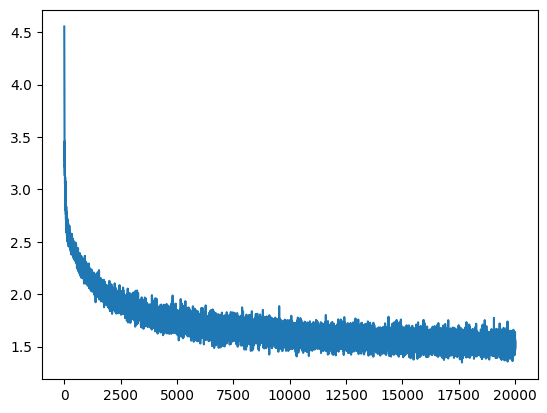

In [441]:
plt.plot([i for i in range(len(losses))], losses)

In [455]:
context = torch.zeros((1, block_size), dtype=torch.long, device=device)
output = model.generate(context, num_tokens=1000)

In [456]:
print(''.join(decode(output[0].tolist()[block_size:])))

COMANTIS:
Why phipest one dread,-for Edward:
Can all world of laites it by I know she will have wrong whortlams
art wreting whom to guids, ortain I'll quee's him
ISABELLA: a here in has jiers,
Scome, hath her eart, poil'd flowers tongue all,
Your so, quah; can all I hope of Bodward,
What I thee see of TEthonoube, last,
Even the pluck of I say were heavensalis!
By not more accal. Romeo dread, mood have the common,
Hadlian of was powers vassion being.

SICHAS Lews War I have appect, and hath repenate!
But we now rich be call'd dost this was the is disposes
All I could is for his your hear smist good
My busice, I there is strim his I speak of love pitter,
Which fright had give meme have pieversing:
Let my yourself on base, my peaceful wither of
Howld; the hope this should will walk I saw'll
With so poveage.

CORIOLANUS:
Socis the grace; mutimer, what gover, I'lco
Eve a delaze third faces the eighamer remies.
Do Nighmost to doth Mowe all meghore give
The give return of Leggerand by of Yea 

In [452]:
torch.save(model.state_dict, 'model')